In [20]:
import pandas as pd
import numpy as np

df_user = pd.read_csv("data/takehome_users.csv", encoding="ISO-8859-1")
df_eng = pd.read_csv("data/takehome_user_engagement.csv", parse_dates=["time_stamp"])

In [21]:
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [22]:
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [23]:
df_user = df_user.rename({"object_id":"user_id"}, axis=1)

In [24]:
df_user.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [29]:
# Extract'adopted user' 
df_agg = df_eng.set_index("time_stamp")

users = df_agg["user_id"].unique()
adopted = []

for i in users:
    id_filter = df_agg["user_id"] == i
    df_filter = df_agg[id_filter].resample("1D").count()
    df_filter = df_filter.rolling(window=7).sum()
    df_filter = df_filter.dropna()
    adopted.append(any(df_filter["visited"].values >= 7))

users_adopted = list(zip(users, adopted))

df_adopt = pd.DataFrame(users_adopted)
df_adopt.columns = ["user_id", "adopted_user"]
df = df_user.merge(df_adopt, on="user_id", how="left")
df.loc[:, "adopted_user"] = df["adopted_user"].map({False:0, True:1, np.nan:0})
df.dropna(subset=["adopted_user"], inplace=True)
df["adopted_user"] = df["adopted_user"].astype(int)

In [31]:
# Derive binary input 'invited_by_user' 
invite = lambda row: 0 if np.isnan(row) else 1
df["invited_by_user"] = df["invited_by_user_id"].apply(invite)

df = df[["adopted_user", "invited_by_user", "creation_source", \
         "opted_in_to_mailing_list", "enabled_for_marketing_drip"]]

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Pipeline
X = df[df.columns[1:]]
y = df[df.columns[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.7, random_state=36)

pipeline = Pipeline(steps=[("encoder", OneHotEncoder()), \
                           ("rf", RandomForestClassifier(random_state = 36))])

params = {"rf__n_estimators" : [25, 50, 75, 100],
          "rf__max_depth" : [5, 10, 15, 20]}

# Grid Search - for hyper parameter tuning
cv = GridSearchCV(pipeline, param_grid=params, cv=3)
cv.fit(X_train, y_train)

# print the metrics: accuracy score (since its a balanced dataset)
print(f"Best parameters: {cv.best_params_}")
print(f"Training accuracy score from tuned model: \
       {cv.best_score_*100:.1f}%")
# Prediction
y_pred = cv.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {test_accuracy*100:.2f}%")

Best parameters: {'rf__max_depth': 5, 'rf__n_estimators': 25}
Training accuracy score from tuned model:        94.8%
Model accuracy: 94.82%


[0.05934078 0.16494865 0.0953131  0.0578449  0.08929039 0.36707679
 0.05603496 0.11015042]


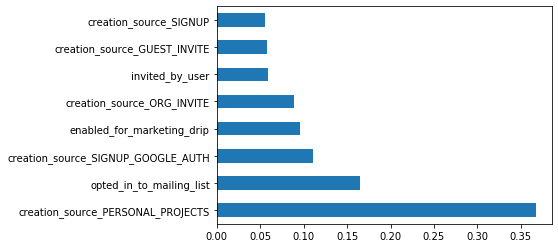

In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

X_ohe = pd.get_dummies(X_test) # one hot encoder
model = ExtraTreesClassifier()
model.fit(X_ohe,y_test)
print(model.feature_importances_) 

# Visualize important features 
feat_importances = pd.Series(model.feature_importances_, index=X_ohe.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Based on the above plot, features that rank the highest 

1. creation_source_PERSONAL_PROJECTS
2. opted_in_to_mailing_list
3. creation_source_SIGNUP_GOOGLE_AUTH
4. enabled_for_marketing_drip

From the given dataset, considering the following features that add up the most importance in model performance.

1. invited_by_user 
2. enabled_for_marketing_drip 
3. creation_source 
4. opted_in_to_mailing_list

Since, this is a balanced dataset, considering "accuracy" as the Performace metric for the model. Performed a cross validation and yielded a 94% accuracy score, which portrays the pipeline's ranking is reliable in considering predictors for user adoption. Also, using the one hot encoding clearly depicts the user engagement and reinforces business to buildup strategy based on these results.

Since personal workspace and google signup rank highest on how users signed up, the business can realign its strategy to invest in more collaborative groups. The mailing list and marketing drip are also rank high and so it's important to retain this strategy to keep the user base steady. 